In [1]:
# !pip install -U pip keras tensorflow

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from google.colab.patches import cv2_imshow



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
import os


zip_train = zipfile.ZipFile('/content/drive/MyDrive/images.zip','r')
zip_train.extractall('/content/sample_data/tmp')
zip_train.close()

In [5]:
def VGG16(rgb=False):

    model = Sequential()

    if rgb:
      model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

    else:
      model.add(Conv2D(input_shape=(224, 224, 1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))

    model.add(Flatten(name='flatten'))

    model.add(Dropout(name="dropout", rate=0.15))

    model.add(Dense(4096, activation="relu", name="fc1"))

    model.add(Dense(4096, activation="relu", name="fc2"))

    # model.add(Dense(512, activation="relu", name="fc4"))

    # model.add(Dense(256, activation="relu", name="fc5"))

    # model.add(Dense(128, activation="relu", name="fc6"))

    model.add(Dense(6, activation="linear", name="output"))

    return model

In [6]:
model = VGG16(rgb=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [7]:
def custom_loss2(y_true, y_pred, pen_factor=500):
    true_x, true_y, true_z, true_roll, true_pitch, true_yaw = tf.split(y_true, 6, axis=-1)
    pred_x, pred_y, pred_z, pred_roll, pred_pitch, pred_yaw = tf.split(y_pred, 6, axis=-1)

    # Compute the mean squared error for each component
    mse_x = tf.keras.losses.mean_squared_error(true_x, pred_x)
    mse_y = tf.keras.losses.mean_squared_error(true_y, pred_y)
    mse_z = tf.keras.losses.mean_squared_error(true_z, pred_z)

    translational_loss = K.sqrt(mse_x + mse_y + mse_z)

    # Penalize rotational components more

    mse_roll = tf.keras.losses.mean_squared_error(true_roll, pred_roll)
    mse_pitch = tf.keras.losses.mean_squared_error(true_pitch, pred_pitch)
    mse_yaw = tf.keras.losses.mean_squared_error(true_yaw, pred_yaw)

    rotational_loss = K.sqrt(mse_roll + mse_pitch + mse_yaw)

    # Compute the overall loss as the sum of individual losses
    total_loss = translational_loss + pen_factor * rotational_loss

    return total_loss

In [8]:
import pandas as pd

poses = pd.read_csv("/content/sample_data/tmp/poses.txt", delimiter=' ', header=None)
print("Size of pose dataframe: ", poses.shape)
# poses.head()

Size of pose dataframe:  (51, 12)


In [9]:
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(5)
second_pose = np.array(poses.iloc[1]).reshape((3,4)).round(5)
print("First pose:\n", first_pose)
print("Second pose:\n",second_pose)

First pose:
 [[ 1.  0.  0.  0.]
 [ 0.  1.  0. -0.]
 [ 0.  0.  1.  0.]]
Second pose:
 [[ 1.000e+00  7.200e-04 -6.900e-04 -1.402e-02]
 [-7.200e-04  1.000e+00 -1.300e-04 -2.820e-02]
 [ 6.900e-04  1.300e-04  1.000e+00  1.199e+00]]


In [10]:
!pip install ipympl --quiet


In [11]:
from google.colab import output
output.enable_custom_widget_manager()
import matplotlib.pyplot as plt

ground_truth = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    ground_truth[i] = np.array(poses.iloc[i]).reshape((3, 4))
#ground_truth

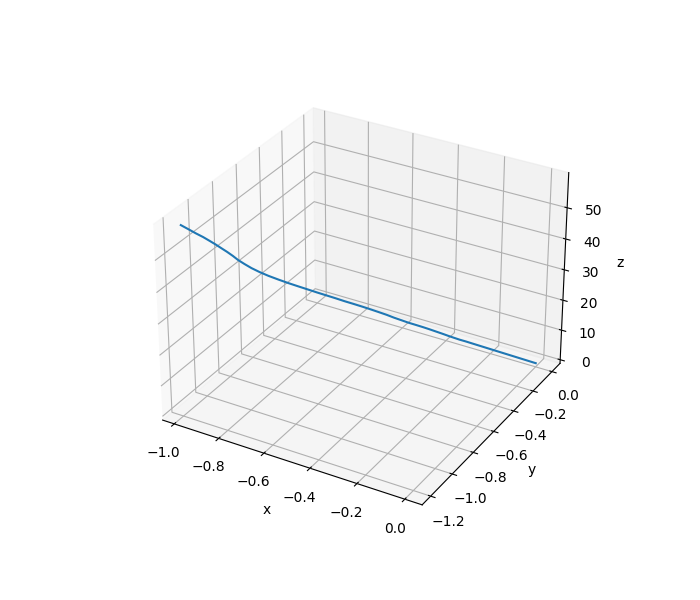

In [12]:
%matplotlib widget
fig = plt.figure(figsize=(7,6))
traj = fig.add_subplot(111, projection='3d')
traj.plot(ground_truth[:,:,3][:,0], ground_truth[:,:,3][:,1], ground_truth[:,:,3][:,2])
traj.set_xlabel('x')
traj.set_ylabel('y')
traj.set_zlabel('z')
plt.show()

In [13]:
import math

# convert the 4x3 matrix to x, y, z, roll, pitch, yaw to use as labels

labels = []
for i in range(len(ground_truth)):
    P = np.array(ground_truth[i])

    R = P[:, :3]
    t = P[:, 3:]

    x = t[:,0][0]
    y = t[:,0][1]
    z = t[:,0][2]


    yaw = np.arctan2(R[2][0], R[2][1])
    pitch = np.arccos(R[2][2])
    roll = -np.arctan2(R[0][2], R[1][2])
    labels.append([x, y, z, yaw, pitch, roll])
    # print(f"X: {x}  Y: {y} Z: {z} yaw: {yaw*180/math.pi} pitch: {pitch*180/math.pi} roll: {roll *180/math.pi}\n")])


# print(len(labels))
labels = np.array(labels)


In [14]:
def centeredCrop(img, output_side_length):
	height, width, depth = img.shape
	new_height = output_side_length
	new_width = output_side_length
	if height > width:
		new_height = output_side_length * height // width
	else:
		new_width = output_side_length * width // height
	height_offset = (new_height - output_side_length) // 2
	width_offset = (new_width - output_side_length) // 2
	cropped_img = img[height_offset:height_offset + output_side_length,
						width_offset:width_offset + output_side_length]
	return cropped_img

In [15]:
import cv2
import numpy as np
from tqdm import tqdm

def preprocess(images, labels):
  images_out = []
  images_cropped = []

  for i in tqdm(range(len(images))):
    X = images[i]
    X = cv2.resize(X, (455, 256))
    X = centeredCrop(X, 224)
    images_cropped.append(np.array(X))

  N = 0
  mean = np.zeros((1, 3, 224, 224))
  for X in tqdm(images_cropped):
    mean[0][0] += X[:,:,0]
    mean[0][1] += X[:,:,1]
    mean[0][2] += X[:,:,2]
    N += 1
  mean[0] /= N
  #Subtract mean from all images
  for X in tqdm(images_cropped):
    X = np.transpose(X,(2,0,1))
    X = X - mean
    X = np.squeeze(X)
    X = np.transpose(X, (1,2,0))
    images_out.append(X)

  return images_out

In [16]:
import os
import cv2

preprocessed_data = []
path = '/content/sample_data/tmp/image_l'
images = []
for filename in os.listdir(path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Assuming your images are in JPEG or PNG format
        # file_path.append(os.path.join(path, filename))

        # Open the image and append it to the list
        img = cv2.imread(os.path.join(path, filename))
        images.append(img)

preprocessed_data = preprocess(images, labels)
preprocessed_data = np.array(preprocessed_data)

# images = np.expand_dims(images, axis=-1)



100%|██████████| 51/51 [00:00<00:00, 1031.96it/s]


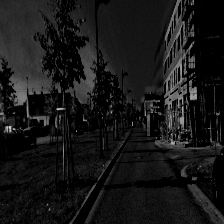

In [17]:
cv2_imshow(preprocessed_data[2])

In [18]:
optim = Adam(learning_rate=1e-05,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08)

In [19]:
# def gen_data(images, labels):
#   while True:
#         indices = range(len(images))
#         random.shuffle(indices)

#         for i in indices:
#           img = np.array(images[i])
#           label = labels[i]
#           yield img, label



In [20]:
# def gen_batches(images, labels, batch_size = 8):
#   data = gen_data(images, labels)
#   while True:
#     img_batch = []
#     label_batch = []

#     for _ in range(batch_size):
#       img, label = next(data)
#       img_batch.append(img)
#       label_batch.append(label)
#     yield img_batch, label_batch


In [21]:
from sklearn.model_selection import train_test_split
images_train, images_test, labels_train, labels_test = train_test_split(preprocessed_data, labels, test_size = 0.25)

In [22]:
model.compile(optimizer=optim, loss=custom_loss2, metrics=['accuracy'])

In [23]:
logdir = 'tflogs'
writer = tf.summary.create_file_writer(logdir)
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir)]

In [24]:
images_train.shape, labels_train.shape

((38, 224, 224, 3), (38, 6))

In [25]:
!tensorboard --logdir tflogs

2023-11-28 21:43:12.176833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 21:43:12.176895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 21:43:12.176924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 21:43:13.329334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose 

In [26]:
history = model.fit(images_train, labels_train, epochs=100, batch_size=4, callbacks=callbacks)



Epoch 1/100
10/10 [==============================] - 12s 101ms/step - loss: 469.4929 - accuracy: 0.0526
Epoch 2/100
10/10 [==============================] - 0s 38ms/step - loss: 269.5902 - accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 37ms/step - loss: 228.4064 - accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 37ms/step - loss: 216.3750 - accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 36ms/step - loss: 230.2973 - accuracy: 0.0263
Epoch 6/100
10/10 [==============================] - 0s 36ms/step - loss: 207.2028 - accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 36ms/step - loss: 192.1169 - accuracy: 0.0263
Epoch 8/100
10/10 [==============================] - 0s 36ms/step - loss: 206.8088 - accuracy: 0.0263
Epoch 9/100
10/10 [==============================] - 0s 36ms/step - loss: 190.5567 - accuracy: 0.0263
Epoch 10/100
10/10 [==============================] - 0s 36ms/st

In [27]:
model.predict(images_test)[0], labels_test[0]

1/1 [==============================] - 1s 709ms/step


(array([-0.13025498, -0.28275114,  2.1274445 ,  1.458393  ,  0.03144782,
         1.7150462 ], dtype=float32),
 array([-5.62741200e-01, -8.73467500e-01,  3.82069000e+01,  1.51412954e+00,
         2.18819356e-02,  1.62185382e+00]))

In [37]:
tqdm(model.evaluate(images_test, labels_test, batch_size=4))

4/4 [==============================] - 0s 11ms/step - loss: 301.4415 - accuracy: 0.9231


  0%|          | 0/2 [00:00<?, ?it/s]

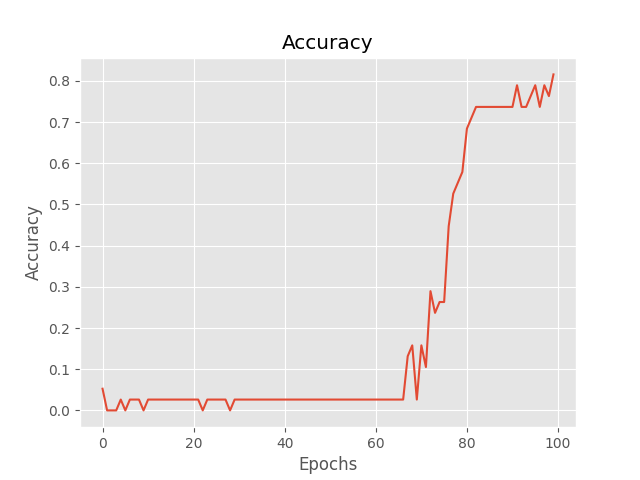

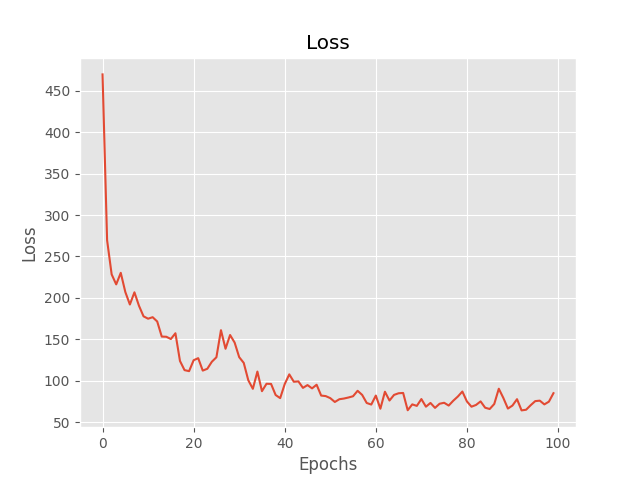

In [36]:
import matplotlib.pyplot as plt
plt.figure()
plt.style.use('ggplot')
x = range(len(history.history['loss']))
plt.style.use('ggplot')
plt.plot(x, history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
# plt.plot(x, history.history['loss'])
plt.show()


plt.figure()
plt.style.use('ggplot')
x = range(len(history.history['loss']))
plt.style.use('ggplot')
plt.plot(x, history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
# plt.plot(x, history.history['loss'])
plt.show()



